In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter

warnings.filterwarnings('ignore')

Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from Alice in Wonderland by Lewis Carroll or Persuasion by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called BoW, or Bag of Words. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.

In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [3]:
# Parse the cleaned novels. This can take a bit.
spacy.prefer_gpu()
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [4]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


Time to bag some words! Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur. We will exclude stopwords and punctuation. In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [5]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [6]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000


,this,sigh,tender,heel,dive,series,charge,flash,important,crab,...,speak,attachment,confusion,mere,rocket,shakespeare,descend,uppercross,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


### Trying out BoW
Now let's give the bag of words features a whirl by trying a random forest.

In [7]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.990282131661442

Test set score: 0.8905075187969925


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.

### BoW with Logistic Regression
Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [8]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(3190, 3062) (3190,)
Training set score: 0.9579937304075236

Test set score: 0.9158834586466166


### BoW with Gradient Boosting
And finally, let's see what gradient boosting can do:

In [9]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.8846394984326019

Test set score: 0.8731203007518797


### Same model, new inputs
What if we feed the model a different novel by Jane Austen, like Emma? Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process Emma the same way we processed the other data, and combine it with the Alice data:

In [10]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma)
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [11]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [12]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

# Emma is quite long, let's cut it down to the same length as Alice.
emma_sents = emma_sents[0:len(alice_sents)]

In [13]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
done


In [14]:
# Let's use logistic regression again.
# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.6976137211036539


col_0,Austen,Carroll
row_0,,
Austen,1564,105
Carroll,706,307


Well look at that! NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland. Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

### Challenge 0:
Recall that the logistic regression model's best performance on the test set was 93%. See what you can do to improve performance. Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires. Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 90%.

### First try, SVM
Pretty terrible, though it hardly overfit.  Try some other approaches.

In [15]:
from sklearn.svm import SVC
clfsv = SVC(gamma='auto')
train = clfsv.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', clfsv.score(X_train, y_train))
print('\nTest set score:', clfsv.score(X_test, y_test))

(3190, 3062) (3190,)
Training set score: 0.6824451410658308

Test set score: 0.6917293233082706


### Tweak Logistic Regression
This was interesting -- accuracy decreased slightly (1%) on the test set, but the overall difference between train and test narrowed; that's less overfitting.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, 
                        fit_intercept=True, intercept_scaling=1, 
                        class_weight=None, random_state=None, 
                        solver='saga', 
                        max_iter=10000, verbose=1.0, 
                        warm_start=False, n_jobs=None)
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))
scores = cross_val_score(lr, X, Y, cv=10)
print('\nCross Validation Scores:', scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 577 epochs took 72 seconds
(3190, 3062) (3190,)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


Training set score: 0.9335423197492163

Test set score: 0.9050751879699248


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 928 epochs took 183 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 813 epochs took 163 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 853 epochs took 167 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 822 epochs took 156 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 729 epochs took 137 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 981 epochs took 188 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 1171 epochs took 222 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 744 epochs took 142 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 974 epochs took 184 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 890 epochs took 171 seconds

Cross Validation Scores: [0.87406015 0.88157895 0.85338346 0.87593985 0.91165414 0.91729323
 0.91353383 0.89097744 0.90977444 0.88301887]


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.8min finished


### How about my old friend, XGBoost?
Hardly any overfitting, though accuracy needs a bump.

In [18]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=6, n_estimators=200, colsample_bylevel=0.2)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.2,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [19]:
print(X_train.shape, y_train.shape)
print('Training set score:', xgb.score(X_train, y_train))
print('\nTest set score:', xgb.score(X_test, y_test))

(3190, 3062) (3190,)
Training set score: 0.9065830721003135

Test set score: 0.8928571428571429


### After many iterations and a lot of turning the knobs, this is the best I can get from XGBoost

In [48]:
xgb = XGBClassifier(max_depth=7, learning_rate=0.2, n_estimators=225, colsample_bylevel=0.3)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=225,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
print('Training set score:', xgb.score(X_train, y_train))
print('\nTest set score:', xgb.score(X_test, y_test))
scores = cross_val_score(xgb, X, Y, cv=5)
print('\nCross Validation Scores:', scores)

Training set score: 0.9347962382445141

Test set score: 0.9041353383458647

Cross Validation Scores: [0.8693609  0.86278195 0.91635338 0.89943609 0.87947269]


### Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work. This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

I'm pulling in Moby Dick by Herman Melville, and will compare with Carroll's Alice in Wonderland.

In [51]:
moby = gutenberg.raw('melville-moby_dick.txt')
moby = re.sub(r'VOLUME \w+', '', moby)
moby = re.sub(r'CHAPTER \w+', '', moby)
moby = text_cleaner(moby)
print(moby[:100])

ETYMOLOGY. (Supplied by a Late Consumptive Usher to a Grammar School) The pale Usher threadbare in c


In [54]:
# Parse our cleaned data.
moby_doc = nlp(moby[:500000])

In [57]:
# Group into sentences.
moby_sents = [[sent, "Melville"] for sent in moby_doc.sents]

# Let's cut it down to the same length as Alice.
moby_sents = moby_sents[0:len(alice_sents)]

In [58]:
# Build a new Bag of Words data frame for Moby word counts.
# We'll use the same common words from Alice and Persuasion.
moby_sentences = pd.DataFrame(moby_sents)
moby_bow = bow_features(moby_sentences, common_words)

print('done')

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
done


In [59]:
# Let's use logistic regression again.
# Combine the Moby sentence data with the Alice data from the test set.
X_Moby_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    moby_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Moby_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Melville'] * moby_bow.shape[0])])

In [60]:
lr = LogisticRegression()
lr.fit(X_Moby_test, y_Moby_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
print('\nTest set score:', lr.score(X_Moby_test, y_Moby_test))
lr_Moby_predicted = lr.predict(X_Moby_test)
pd.crosstab(y_Moby_test, lr_Moby_predicted)


Test set score: 0.9347501864280388


col_0,Carroll,Melville
row_0,,
Carroll,856,157
Melville,18,1651


              precision    recall  f1-score   support

     Carroll       0.98      0.85      0.91      1013
    Melville       0.91      0.99      0.95      1669

   micro avg       0.93      0.93      0.93      2682
   macro avg       0.95      0.92      0.93      2682
weighted avg       0.94      0.93      0.93      2682



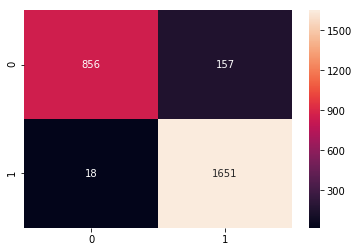

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_Moby_test,lr_Moby_predicted))
sns.heatmap(confusion_matrix(y_Moby_test,lr_Moby_predicted),annot=True,fmt='d')
plt.show()